In [1]:
# libraries
using Flux             # the julia ml library
using Images           # image processing and machine vision for julia
using MLJ              # make_blobs
using MLDataUtils      # label, nlabel, labelfreq
using MLDatasets       # mnist

using GLM              # lm, glm

using LinearAlgebra    # pinv pseudo-inverse matrix
using Metrics          # r2-score
using Random
using StatsBase        # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


In [2]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();
length(trainY_original), length(validationY_original)

(60000, 10000)

,,,,

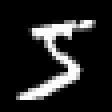
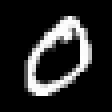
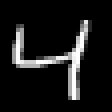
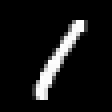
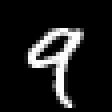

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [3]:
display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

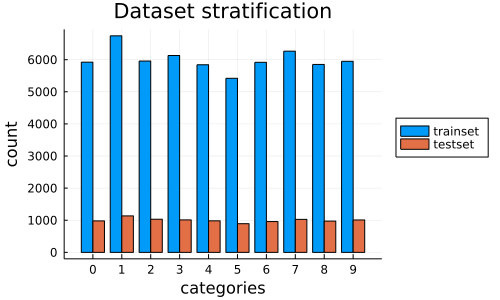

In [4]:
# distribution of labels
function categoryStratificationChart(trainY, testY)
    # using MLDataUtils
    
    # check for unique labels
    l = label(trainY); sort!(l)
    N = nlabel(trainY)

    # trainset classes
    d1 = labelfreq(trainY)
    d1 = DataFrame([(k, v) for (k,v) in d1])
    rename!(d1, ["class","trainset"])

    # testset classes
    d2 = labelfreq(testY)
    d2 = DataFrame([(k, v) for (k,v) in d2])
    rename!(d2, ["class","testset"])

    # make a single df (df facilitates sorting)
    df = leftjoin(d1, d2, on = :class)
    sort!(df,[:class])

    # make a matrix out of df (matrix facilitates plotting)
    M = df |> Array
    p1 = groupedbar(M[:, 2:3],
        bar_position = :dodge,
        size=(500,300),
        xtick=(1:N, l),   # não é obvio chegar a esta configuração
        legend=:outerright,
        label=["trainset" "testset"])
    p1 = title!("Dataset stratification", xlabel="categories", ylabel="count")
end

categoryStratificationChart(trainY_original, validationY_original)

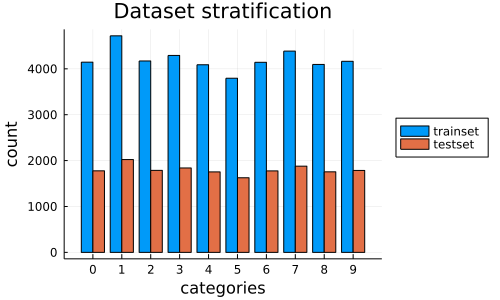

In [5]:
#(trX, trY), (vX, vY) = splitobs((trainX, trainY), at = 0.7);
(trX, trY), (teX, teY) = stratifiedobs((trainX_original, trainY_original), p = 0.7); ### proporção aqui é "p", em splitjobs é "at"
categoryStratificationChart(trY, teY)

#### Linear regression

In [6]:
# dataset to X,y arrays

function matrix2vector(M)
    d = length(M)
    v = reshape(M, (d,))   # columns are organized left-to-right as single vector
end

function imageSet2rowMatrix(imageSet)
    # converts an image set (rows x columns x N) 3D-array on a (vector x N) 2D-array
    # each row of the matrix corresponds to one image

    N = size(imageSet)[3]
    d = size(imageSet)[1] * size(imageSet)[2]

    X = [ matrix2vector(imageSet[:, :, i]) for i in 1:N ]
    X = DataFrame(X, :auto) |> Matrix
    X = X' |> Matrix
    return X
end

trainX = imageSet2rowMatrix(trX)
testX  = imageSet2rowMatrix(teX)
validationX = imageSet2rowMatrix(validationX_original)

trainY = copy(trY)
testY  = copy(teY)
validationY = copy(validationY_original);

In [19]:
# fit the model
lmFit = lm(Float64.(trainX), trainY);   # converter X para Float64
lmFit

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
               Coef.   Std. Error       t  Pr(>|t|)       Lower 95%      Upper 95%
──────────────────────────────────────────────────────────────────────────────────
x1       0.0          NaN          NaN       NaN      NaN            NaN
x2       0.0          NaN          NaN       NaN      NaN            NaN
x3       0.0          NaN          NaN       NaN      NaN            NaN
x4       0.0          NaN          NaN       NaN      NaN            NaN
x5       0.0          NaN          NaN       NaN      NaN            NaN
x6       0.0          NaN          NaN       NaN      NaN            NaN
x7       0.0          NaN          NaN       NaN      NaN            NaN
x8       0.0          NaN          NaN       NaN      NaN            NaN
x9       0.0          NaN          NaN 